In [1]:
from os.path import join
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import seaborn as sns
from tqdm import trange
import xarray as xr

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.diverging'] = 'vlag'
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False

In [3]:
dims = ['alpha_x', 'alpha_y', 'beta_x', 'beta_y']
eps_labels = [r'$\varepsilon_x$', r'$\varepsilon_y$', r'$\varepsilon_1$', r'$\varepsilon_2$']
twiss_labels = [r'$\alpha_x$', r'$\alpha_y$', r'$\beta_x$', r'$\beta_y$']  
twiss_labels_dict = {dim: label for dim, label in zip(dims, twiss_labels)}

Load the data.

In [4]:
folder = '_output/data/'

In [5]:
def loadtxt(filename):
    return np.loadtxt(join(folder, filename))

def load_pickled_file(filename):
    filename = join(folder, filename)
    file = open(filename, 'rb')
    data = pickle.load(file)
    file.close()
    return data

def load_data(filename):
    data = load_pickled_file(filename)
    data = np.array(data)
    data *= 1e6
    data = xr.DataArray(
        data, 
        dims=dims+['emittance'], 
        coords={'alpha_x': alpha_xs, 
                'alpha_y': alpha_ys, 
                'beta_x': beta_xs, 
                'beta_y': beta_ys}
    )
    return data

def mismatch_parameter(alpha1, beta1, alpha2, beta2):
    def gamma(alpha, beta):
        return (1.0 + alpha**2) / beta
    gamma1 = gamma(alpha1, beta1)
    gamma2 = gamma(alpha2, beta2)
    return 0.5 * (beta1 * gamma2 - 2.0 * alpha1 * alpha2 + gamma1 * beta2)

In [6]:
cvals = loadtxt('cvals.dat')
run_indices = list(range(len(cvals)))

In [7]:
alpha_xs = loadtxt('alpha_xs.dat')
alpha_ys = loadtxt('alpha_ys.dat')
beta_xs = loadtxt('beta_xs.dat')
beta_ys = loadtxt('beta_ys.dat')
alpha_x_true, alpha_y_true, beta_x_true, beta_y_true = loadtxt('true_twiss.dat')
fail_rates_list, stds_list, errs_list, frac_stds_list, frac_errs_list = [], [], [], [], []
eps_true_list = []
for run in run_indices:    
    fail_rates = np.array(load_pickled_file('fail_rates_{}.pkl'.format(run)))
    fail_rates = xr.DataArray(
        fail_rates,
        dims=dims,
        coords={'alpha_x': alpha_xs, 
                'alpha_y': alpha_ys, 
                'beta_x': beta_xs, 
                'beta_y': beta_ys},
    )
    means = load_data('emittance_means_{}.pkl'.format(run))
    stds = load_data('emittance_stds_{}.pkl'.format(run))
    eps_x_true, eps_y_true, eps_1_true, eps_2_true = 1e6 * loadtxt('true_emittances_{}.dat'.format(run))
    eps_true = np.array([eps_x_true, eps_y_true, eps_1_true, eps_2_true])
    errs = eps_true - means
    frac_stds = stds / eps_true
    frac_errs = errs / eps_true
    eps_true_list.append(eps_true)
    fail_rates_list.append(fail_rates)
    stds_list.append(stds)
    errs_list.append(errs)
    frac_stds_list.append(frac_stds)
    frac_errs_list.append(frac_errs)

In [8]:
M_list = []
for run in run_indices:
    Mx = np.zeros((len(alpha_xs), len(alpha_ys), len(beta_xs), len(beta_ys)))
    My = np.zeros((len(alpha_xs), len(alpha_ys), len(beta_xs), len(beta_ys)))
    for i, alpha_x in enumerate(alpha_xs):
        for k, beta_x in enumerate(beta_xs):
            for j, alpha_y in enumerate(alpha_ys):
                for l, beta_y in enumerate(beta_ys): 
                    Mx[i, j, k, l] = mismatch_parameter(alpha_x, beta_x, alpha_x_true, beta_x_true)
                    My[i, j, k, l] = mismatch_parameter(alpha_y, beta_y, alpha_y_true, beta_y_true)
    M = Mx + My
    M_list.append(M)

Plotting

In [9]:
def correct_xlim(ax):
    xlim = ax.get_xlim()
    if xlim[1] < xlim[0]:
        ax.set_xlim(list(reversed(ax.get_xlim())))

eps1 = 20.00, eps2 = 20.00


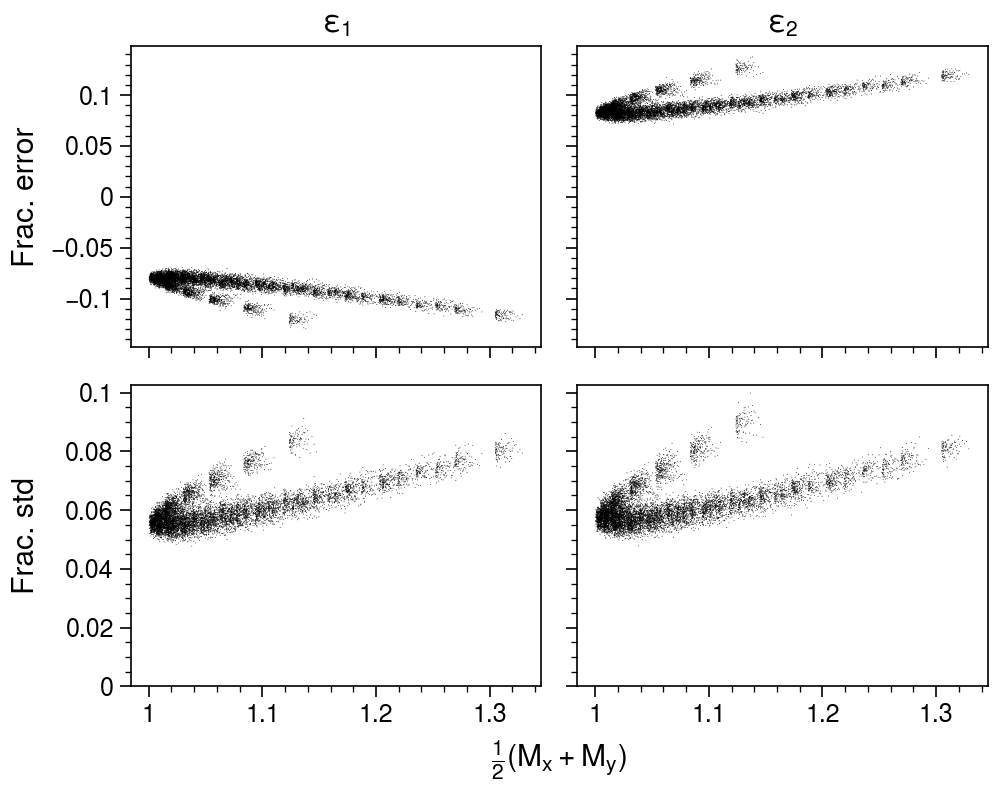

eps1 = 23.33, eps2 = 16.67


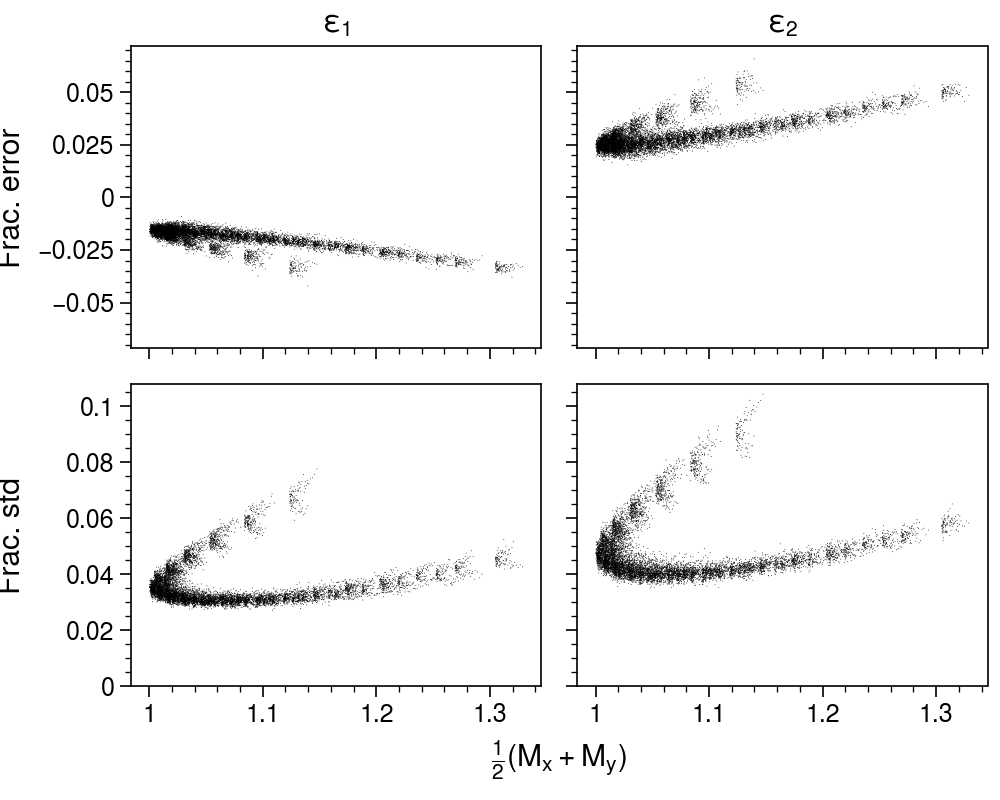

eps1 = 26.67, eps2 = 13.33


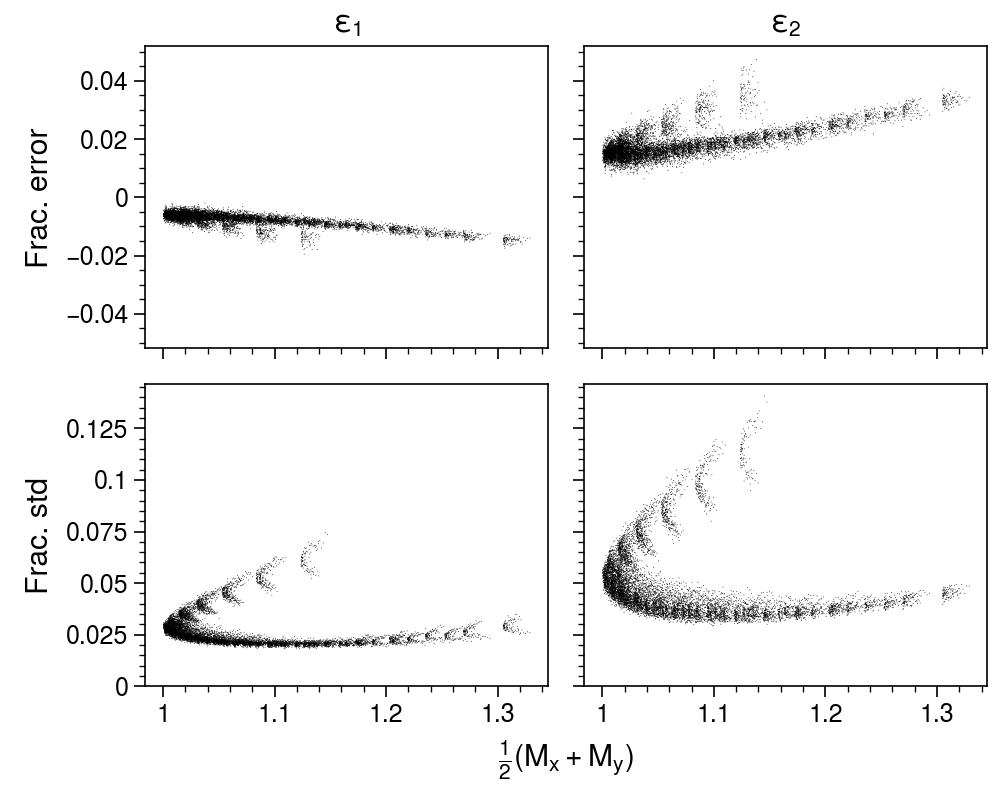

eps1 = 30.00, eps2 = 10.00


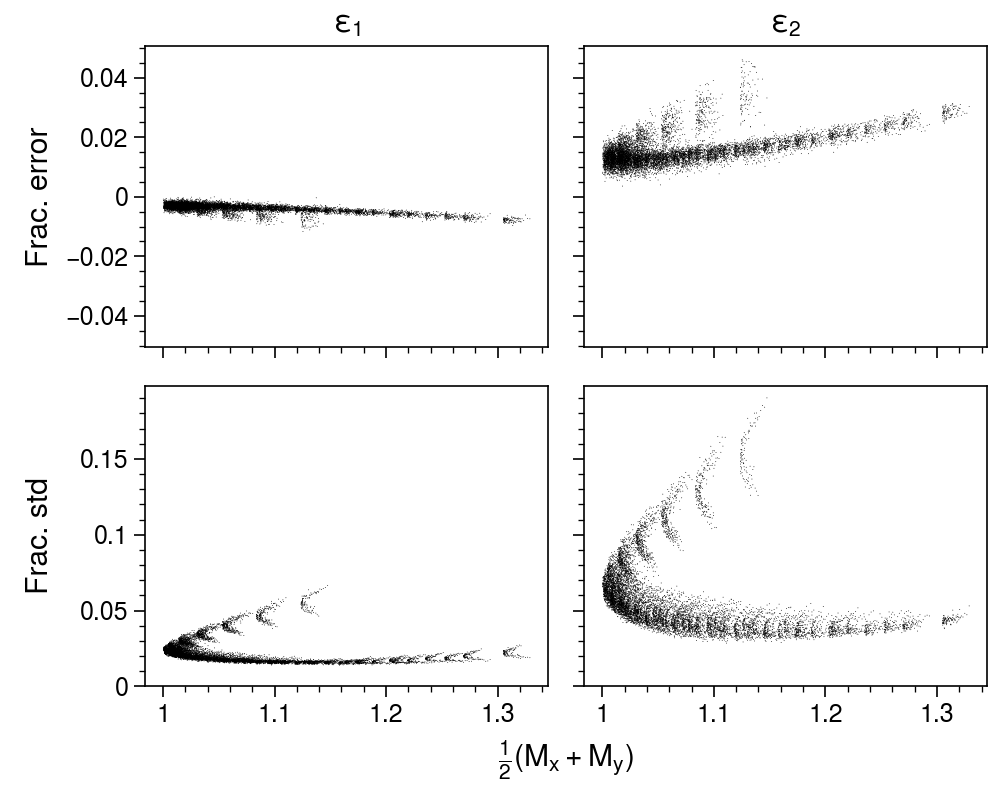

In [10]:
for run in run_indices:
    eps_true = eps_true_list[run]
    print('eps1 = {:.2f}, eps2 = {:.2f}'.format(eps_true[2], eps_true[3]))
    frac_errs = frac_errs_list[run]
    frac_stds = frac_stds_list[run]
    M = M_list[run]

    fig, axes = pplt.subplots(
        nrows=2, ncols=2, 
        figsize=(5.0, 4.0), 
        sharey=False, spany=False, aligny=True
    )
    fontsize = 'large'
    label_kw = dict(fontsize=fontsize)
    axes.format(xlabel_kw=label_kw, ylabel_kw=label_kw, title_kw=label_kw)


    kws = dict(c='black', s=0.1, ec='None')
    x = 0.5 * M.ravel()
    for j in range(2):
        for i, data in enumerate([frac_errs, frac_stds]):
            y = data[..., j + 2].values.ravel()
            axes[i, j].scatter(x, y, **kws)
    axes.format(xlabel=r'$\frac{1}{2} (M_x + M_y)$')
    axes[0, 0].format(ylabel='Frac. error')
    axes[1, 0].format(ylabel='Frac. std')

    ymax = np.max(np.abs([ax.get_ylim() for ax in axes[0, :]]))
    ymax *= 1.05
    # ymax = 0.15
    axes[0, :].format(ylim=(-ymax, ymax))

    ymax = np.max(np.abs([ax.get_ylim() for ax in axes[1, :]]))
    axes[1, :].format(ylim=(0.0, ymax))

    xlims = np.zeros((2, 2, 2))
    ylims = np.zeros((2, 2, 2))
    for i in range(2):
        for j in range(2):
            xlims[i, j] = axes[i, j].get_xlim()
            ylims[i, j] = axes[i, j].get_ylim()

    for ax, label in zip(axes[0, :], eps_labels[2:]):
        ax.set_title(label, fontsize=fontsize)
    axes[:, 1].format(yticklabels=[])
    # plt.savefig('figures/mismatch_')
    plt.show()

eps1 = 20.00, eps2 = 20.00


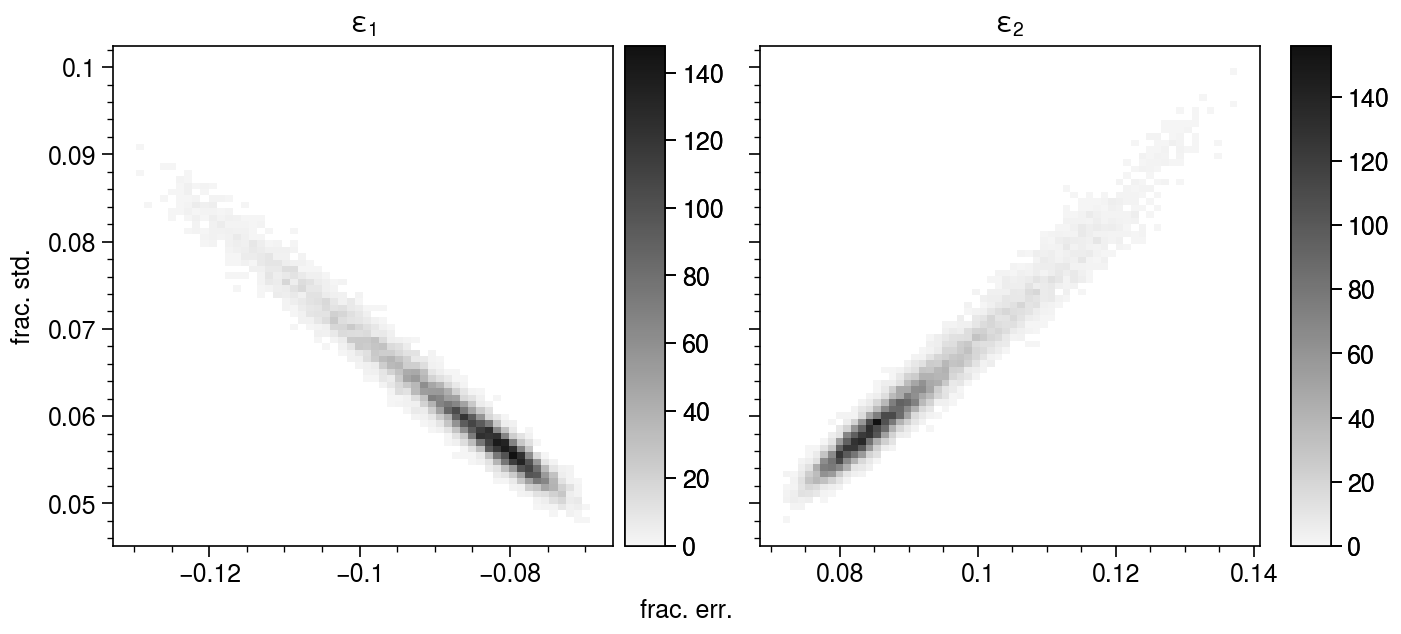

eps1 = 23.33, eps2 = 16.67


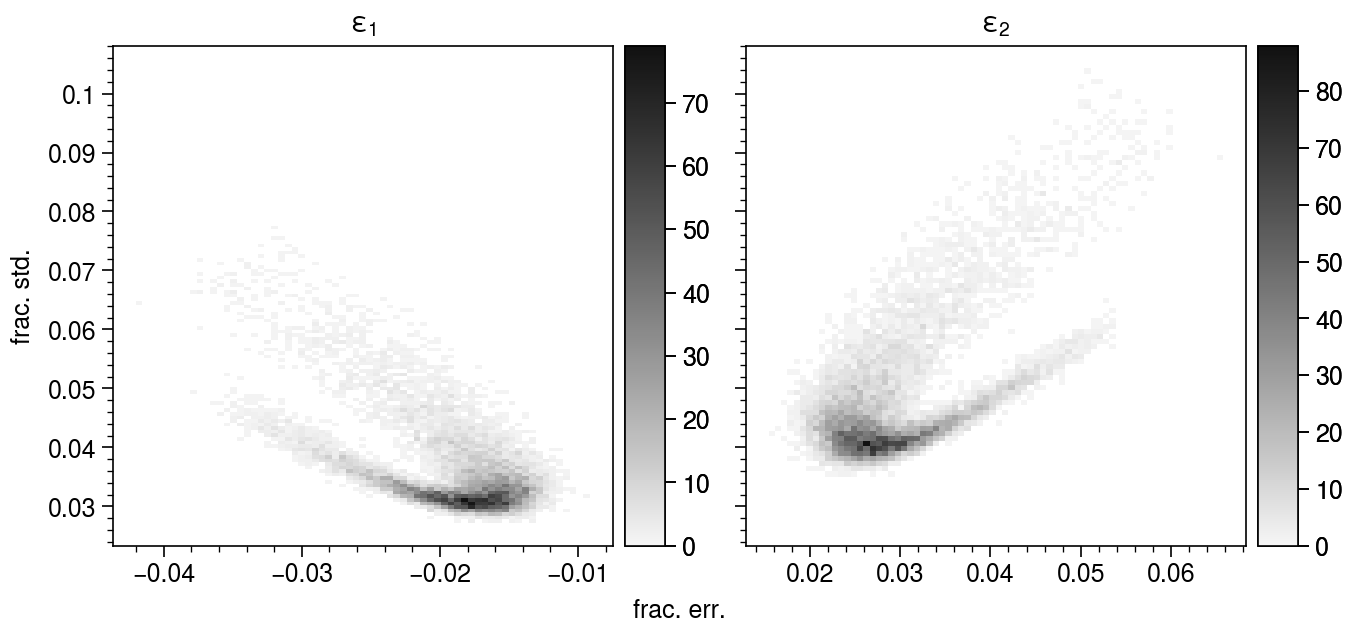

eps1 = 26.67, eps2 = 13.33


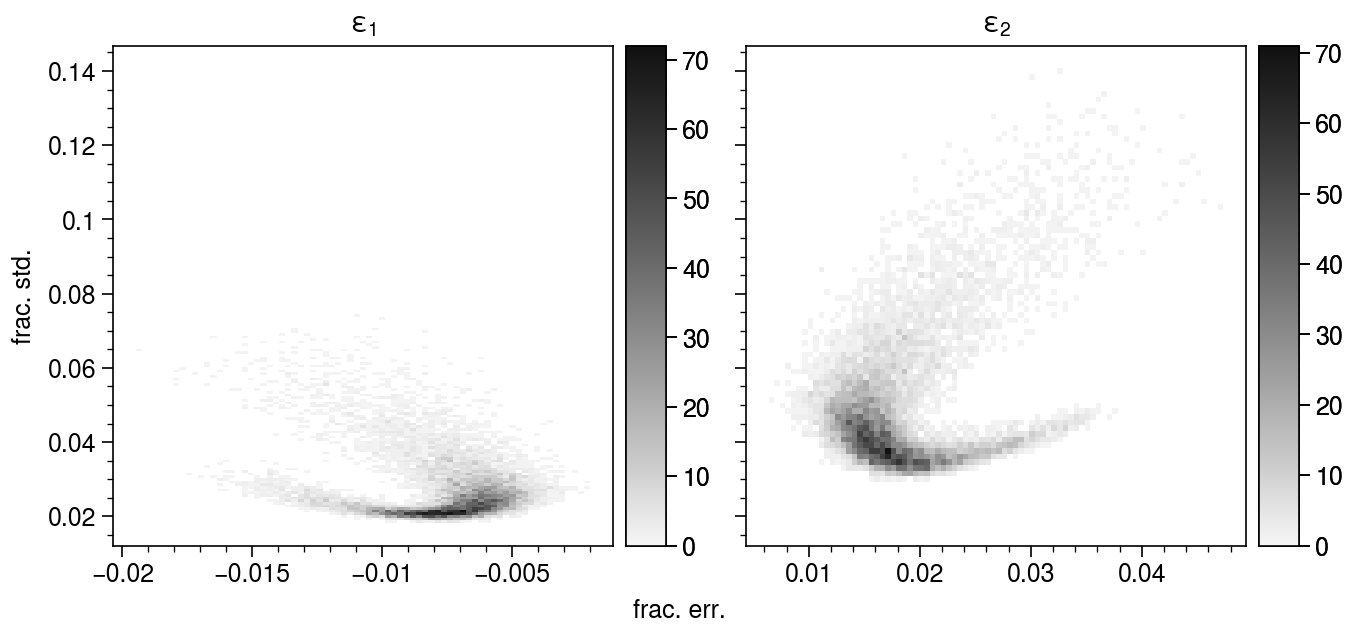

eps1 = 30.00, eps2 = 10.00


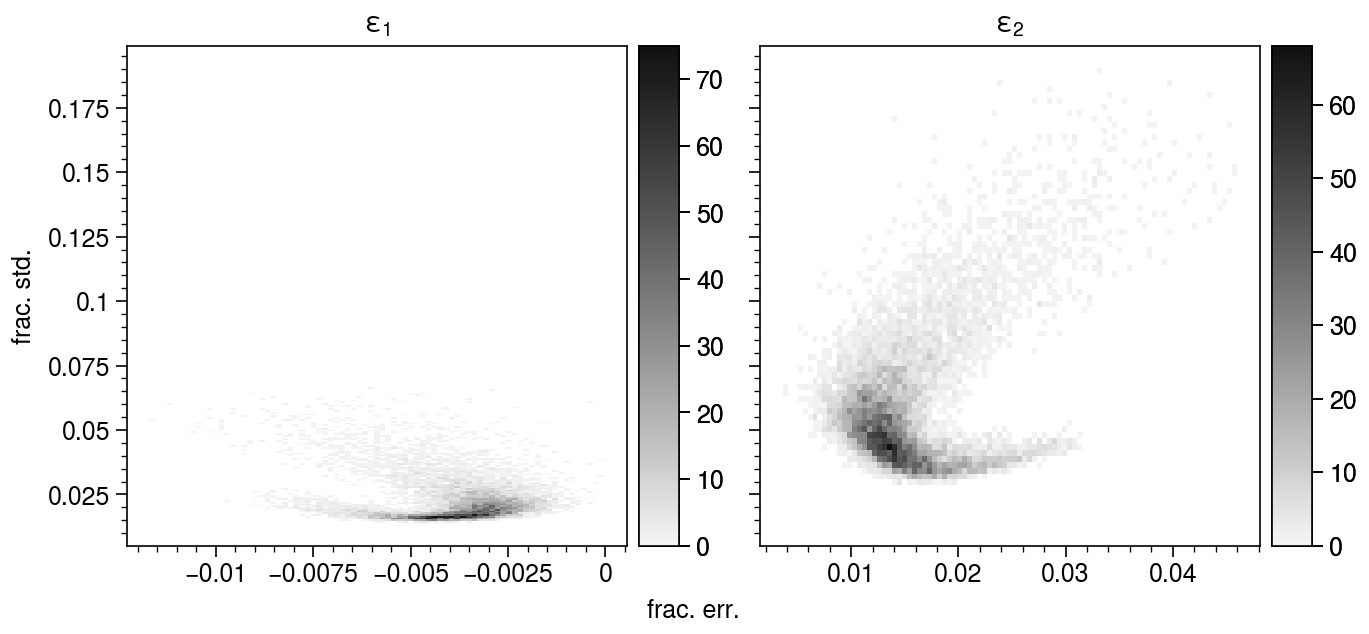

In [11]:
for run in run_indices:
    eps_true = eps_true_list[run]
    print('eps1 = {:.2f}, eps2 = {:.2f}'.format(eps_true[2], eps_true[3]))
    xdata = frac_errs_list[run]
    ydata = frac_stds_list[run]
    fig, axes = pplt.subplots(ncols=2)
    for i, ax in zip([2, 3], axes):
        x = xdata[..., i].values.ravel()
        y = ydata[..., i].values.ravel()
        cmap = pplt.Colormap('mono', left=0.03, right=0.95)
        sns.histplot(ax=ax, x=x, y=y, cmap=cmap, ec='None', colorbar=True)
        ax.format(xlabel='frac. err.', ylabel='frac. std.', title=eps_labels[i])
    # plt.savefig('/Users/46h/Downloads/_mismatch{}'.format('_unequal_emittances' if unequal else ''))
    plt.show()

eps1 = 20.00, eps2 = 20.00


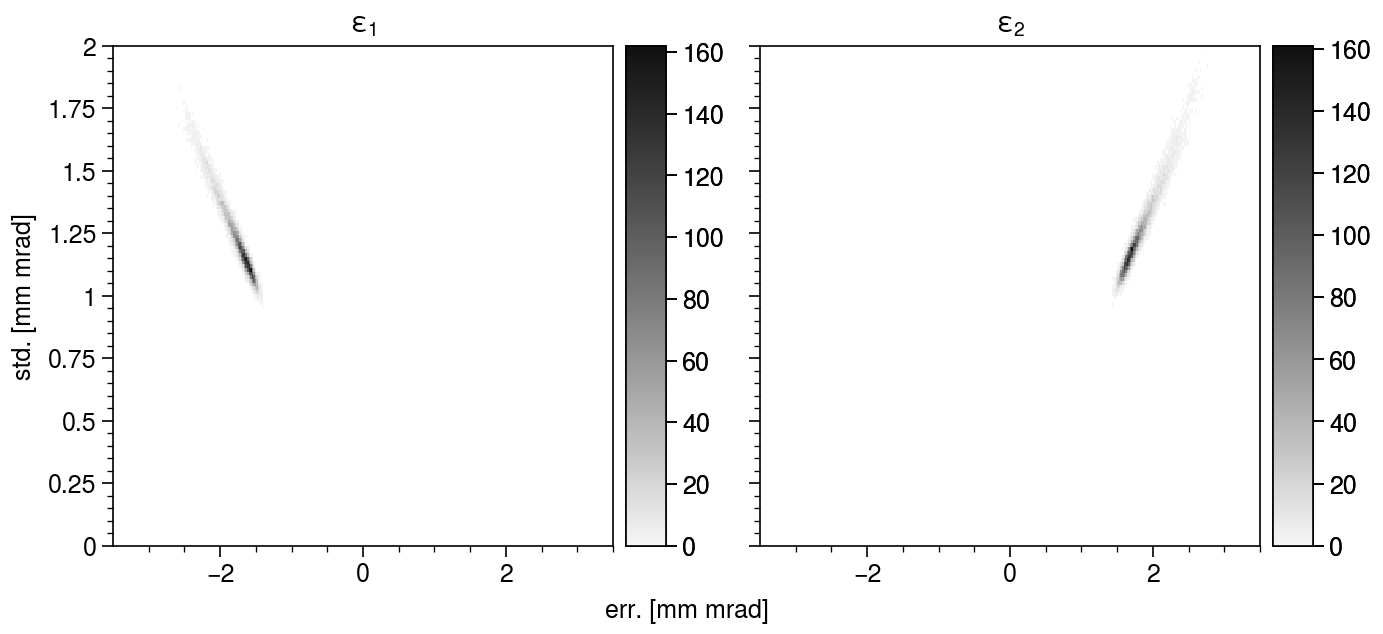

eps1 = 23.33, eps2 = 16.67


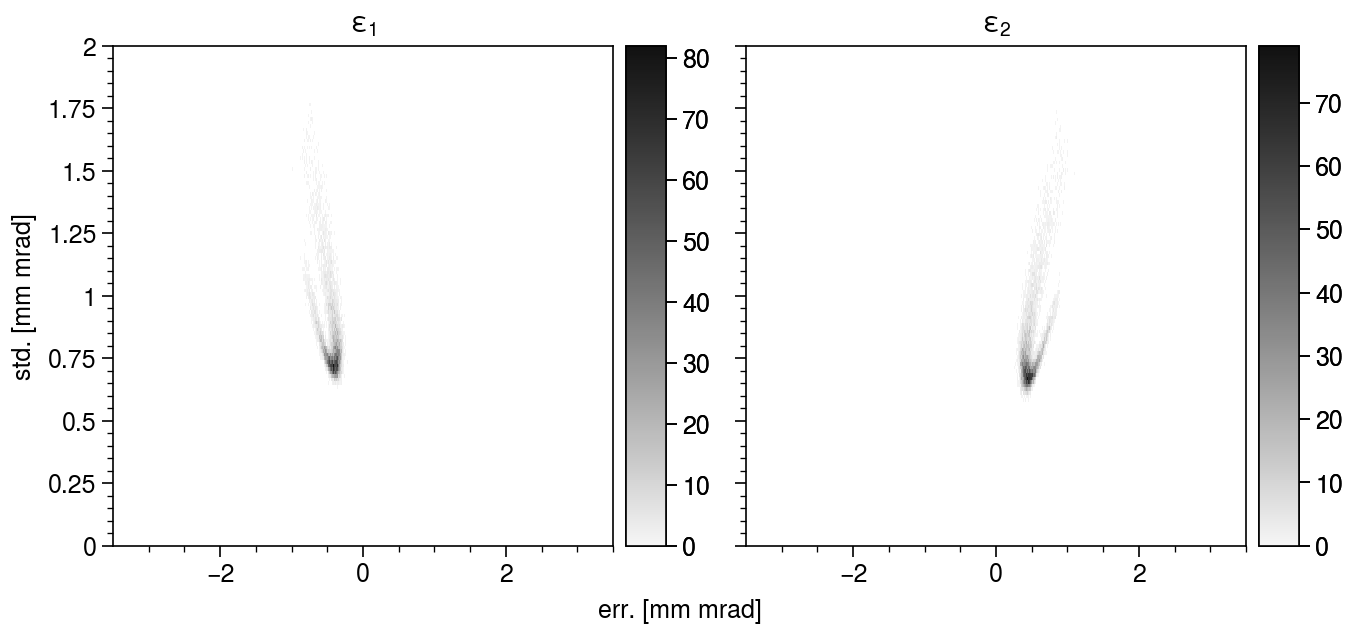

eps1 = 26.67, eps2 = 13.33


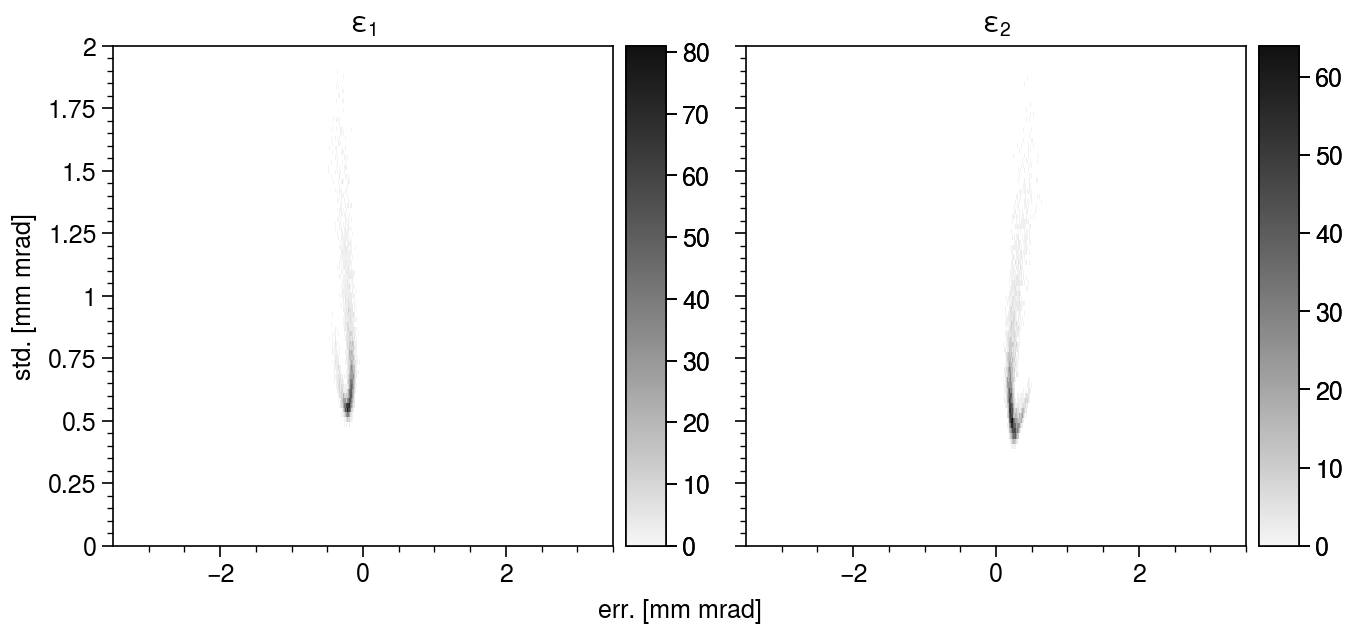

eps1 = 30.00, eps2 = 10.00


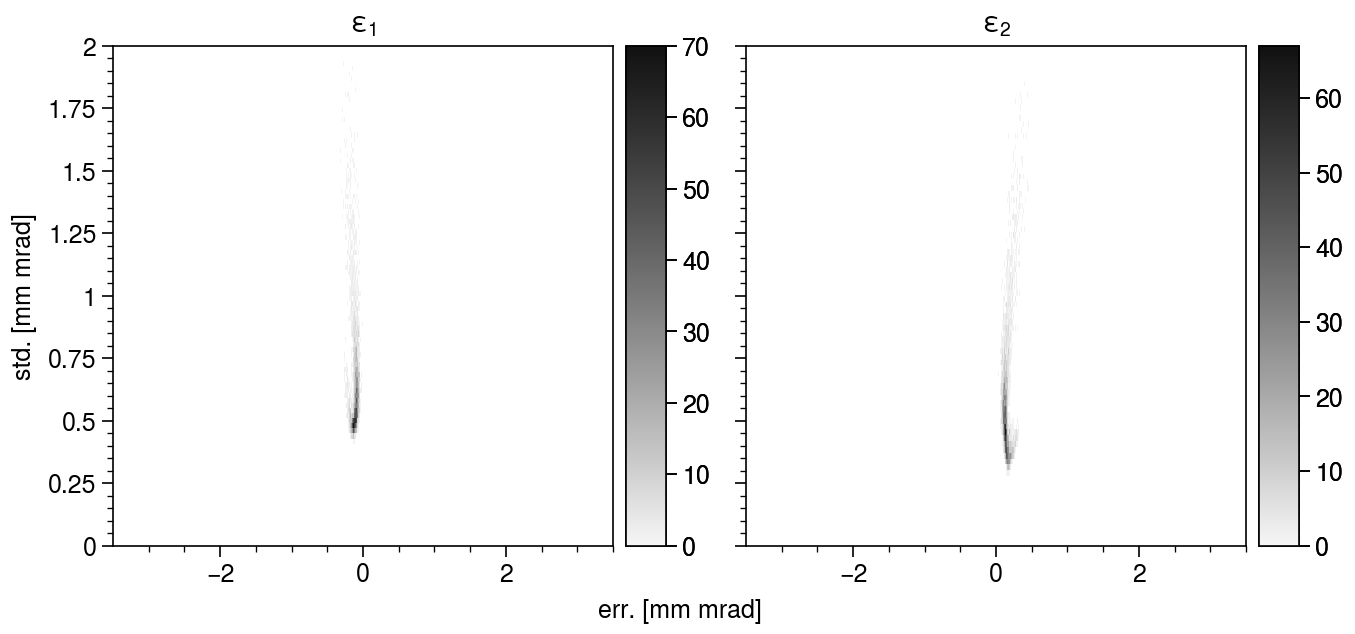

In [12]:
lims = [(-3.5, 3.5), (0.0, 2.0)]
for run in run_indices:
    eps_true = eps_true_list[run]
    print('eps1 = {:.2f}, eps2 = {:.2f}'.format(eps_true[2], eps_true[3]))
    xdata = errs_list[run]
    ydata = stds_list[run]
    fig, axes = pplt.subplots(ncols=2)
    axes.format(xlim=lims[0], ylim=lims[1])
    for i, ax in zip([2, 3], axes):
        x = xdata[..., i].values.ravel()
        y = ydata[..., i].values.ravel()
        cmap = pplt.Colormap('mono', left=0.03, right=0.95)
        sns.histplot(ax=ax, x=x, y=y, binrange=lims, cmap=cmap, ec='None', colorbar=True)
        ax.format(xlabel='err. [mm mrad]', ylabel='std. [mm mrad]', title=eps_labels[i])
    # plt.savefig('/Users/46h/Downloads/_mismatch{}'.format('_unequal_emittances' if unequal else ''))
    plt.show()

In [13]:
# colors = pplt.Cycle('colorblind').by_key()['color']
# colors = colors[:2]
# colors = ['red', 'blue']
cmap_kws = dict(left=0.1, right=1.0)
# cmap1 = pplt.Colormap(colors[0], **cmap_kws)
# cmap2 = pplt.Colormap(colors[1], **cmap_kws)
offset = 0.1
# cmap1 = pplt.Colormap('Vlag', left=0.5 + offset, right=1.0)
# cmap2 = pplt.Colormap('Vlag_r', left=0.5 + offset, right=1.0)
cmap1 = pplt.Colormap('reds', left=offset)
cmap2 = pplt.Colormap('blues', left=offset)
cmaps = [cmap1, cmap2]

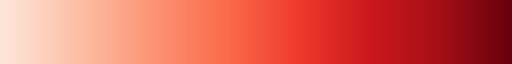

In [14]:
cmap1

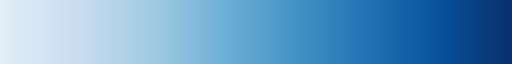

In [15]:
cmap2

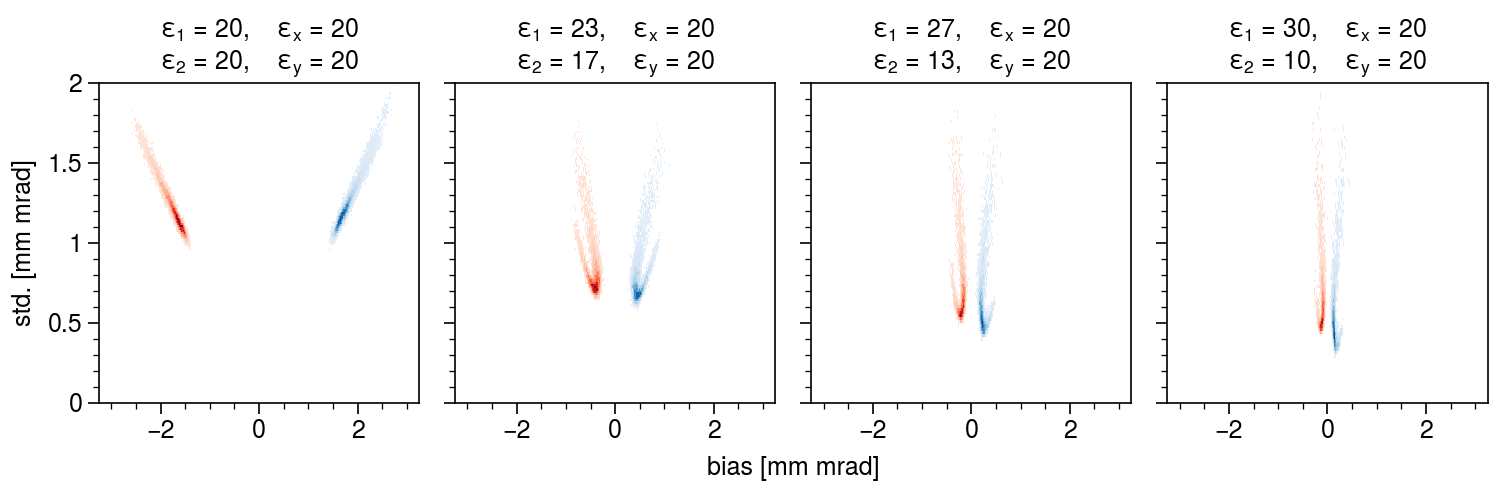

In [16]:
lims = [(-3.25, 3.25), (0.0, 2.0)]
label_kw = dict(fontsize=None)

fig, axes = pplt.subplots(ncols=4, figwidth=7.5)
axes.format(xlim=lims[0], ylim=lims[1], xlabel='bias [mm mrad]', ylabel='std. [mm mrad]',
            xlabel_kw=label_kw, ylabel_kw=label_kw, title_kw=label_kw)
for ax, run in zip(axes, run_indices):
    eps_true = eps_true_list[run]
    xdata = errs_list[run]
    ydata = stds_list[run]
    mappables = []
    for i in ([2, 3]):
        x = xdata[..., i].values.ravel()
        y = ydata[..., i].values.ravel()
        xedges = np.histogram_bin_edges(x, 'auto', lims[0])
        yedges = np.histogram_bin_edges(y, 'auto', lims[1])
        Z, _, _ = np.histogram2d(x, y, bins=[xedges, yedges])
        Z = np.ma.masked_less_equal(Z, 0.0)
        m = ax.pcolormesh(xedges, yedges, Z.T, cmap=cmaps[i - 2], ec='None')
        mappables.append(m)
#         sns.histplot(ax=ax, x=x, y=y, binrange=lims, cmap=cmaps[i - 2], ec='None')
    string1 = fr'$\varepsilon_1$ = {eps_true[2]:.0f},    $\varepsilon_x$ = {eps_true[0]:.0f}'
    string2 = fr'$\varepsilon_2$ = {eps_true[3]:.0f},    $\varepsilon_y$ = {eps_true[1]:.0f}'
    ax.format(title=''.join([string1, '\n', string2]))
    
# cbar_kws = dict(width=0.1, space=None, ticks=[])
# axes[-1].colorbar(mappables[0], label=eps_labels[2], **cbar_kws)
# axes[-1].colorbar(mappables[1], label=eps_labels[3], **cbar_kws)
with pplt.rc.context(savefigdpi=700):
    plt.savefig('_output/figures/mismatch')
plt.show()

In [17]:
filenames = [
    '0.0001_5_5_5_5.pkl',
    '0.166666666667_5_5_5_5.pkl',
    '0.333333333333_5_5_5_5.pkl',
    '0.5_5_5_5_5.pkl',
]
emittances_list = [1e6 * np.array(load_pickled_file(filename)) for filename in filenames]

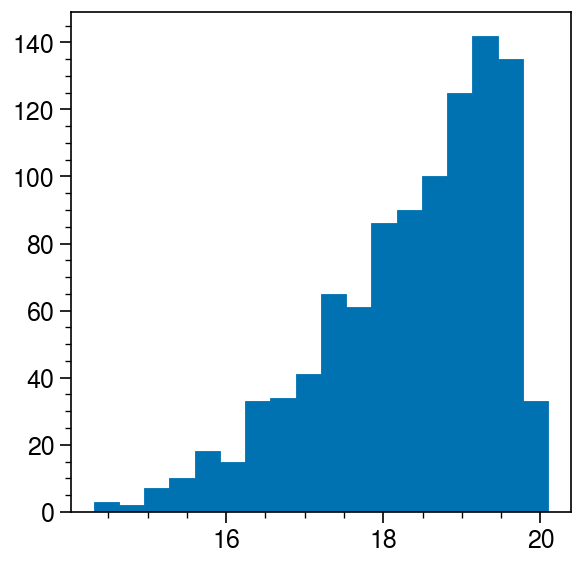

In [18]:
fig, ax = pplt.subplots()
ax.hist(emittances_list[0][:, 3], bins='auto');

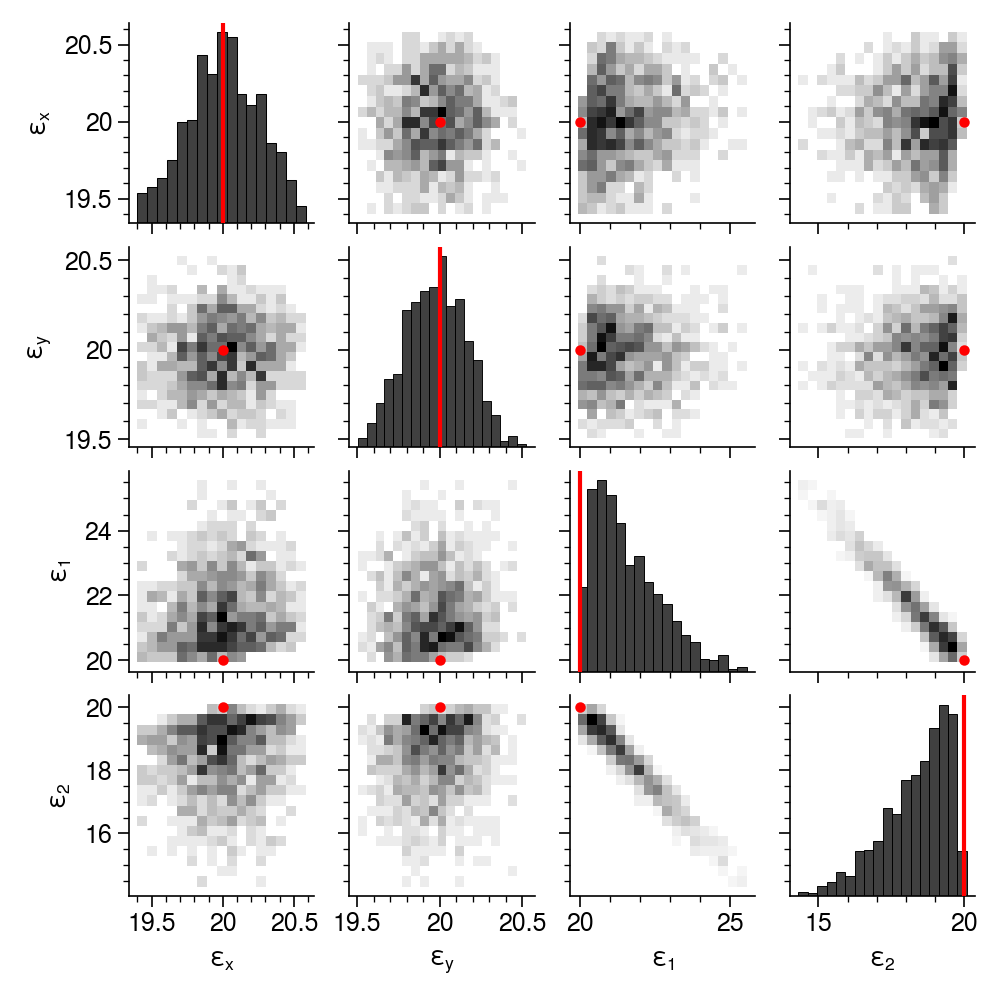

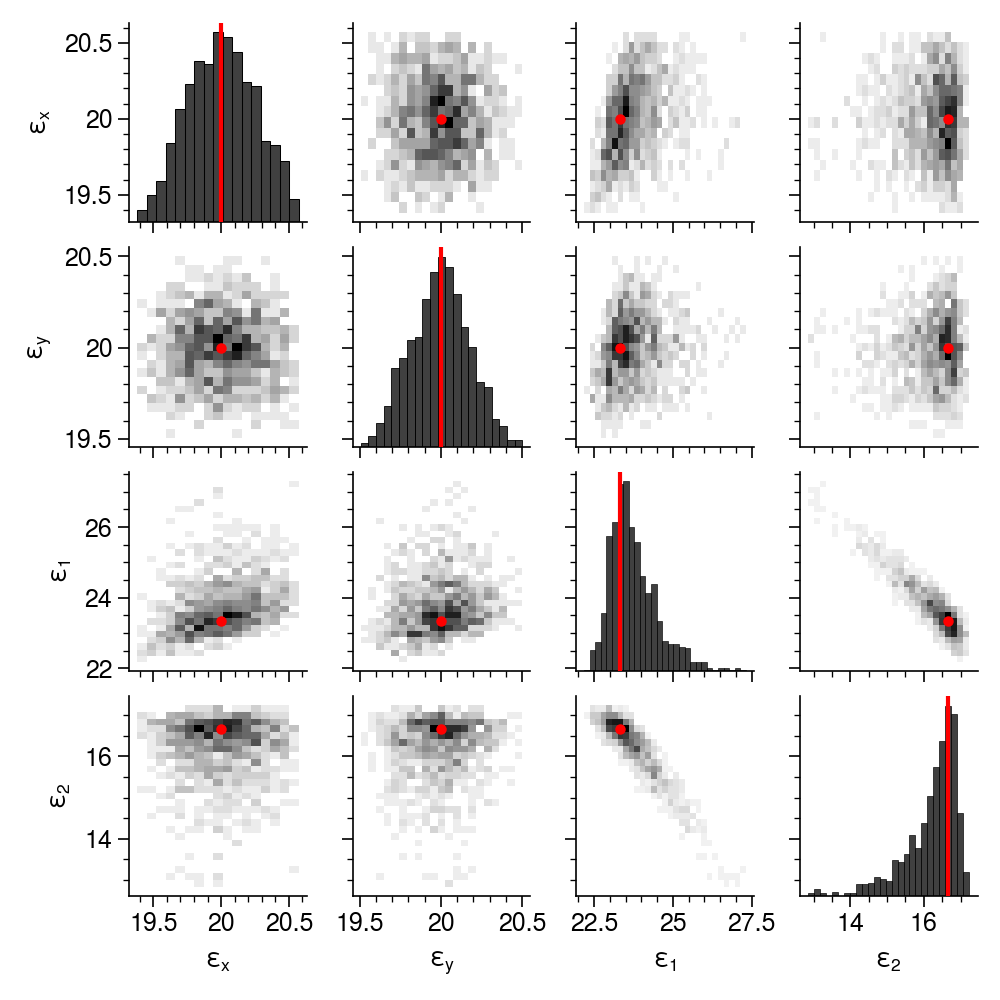

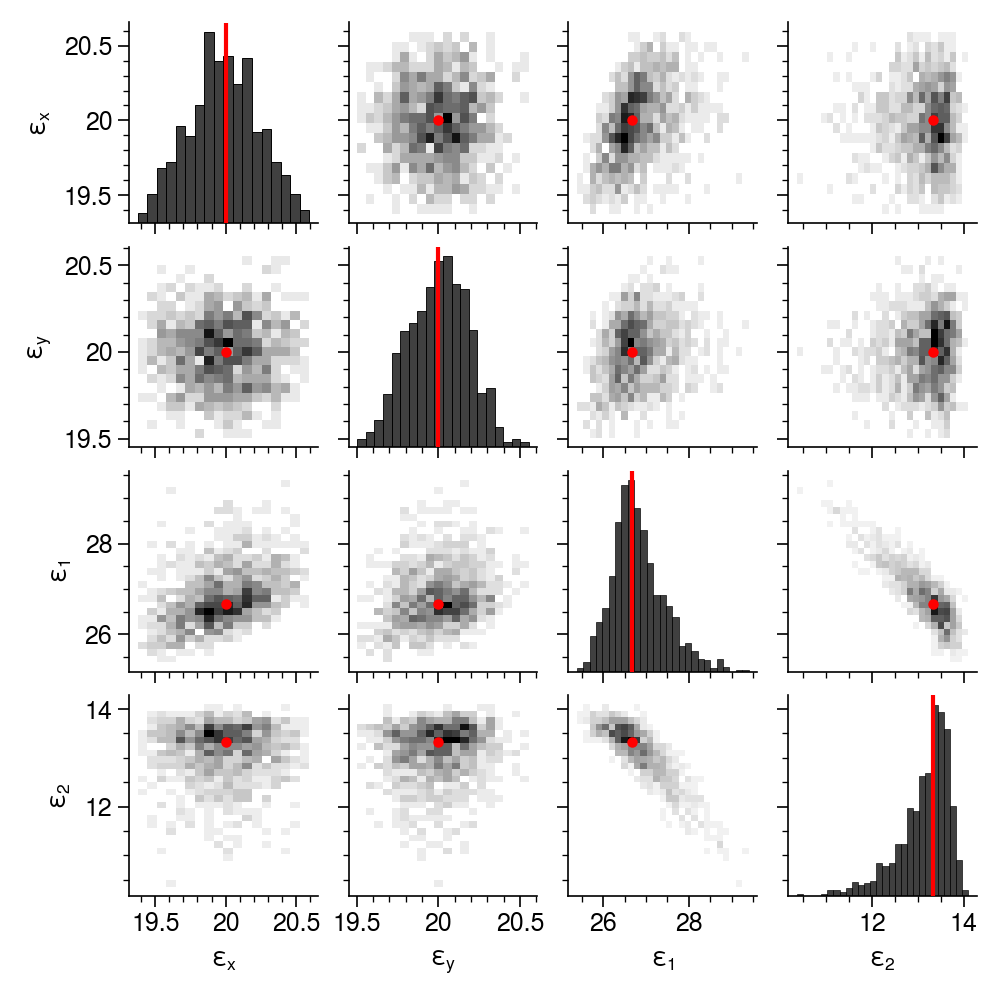

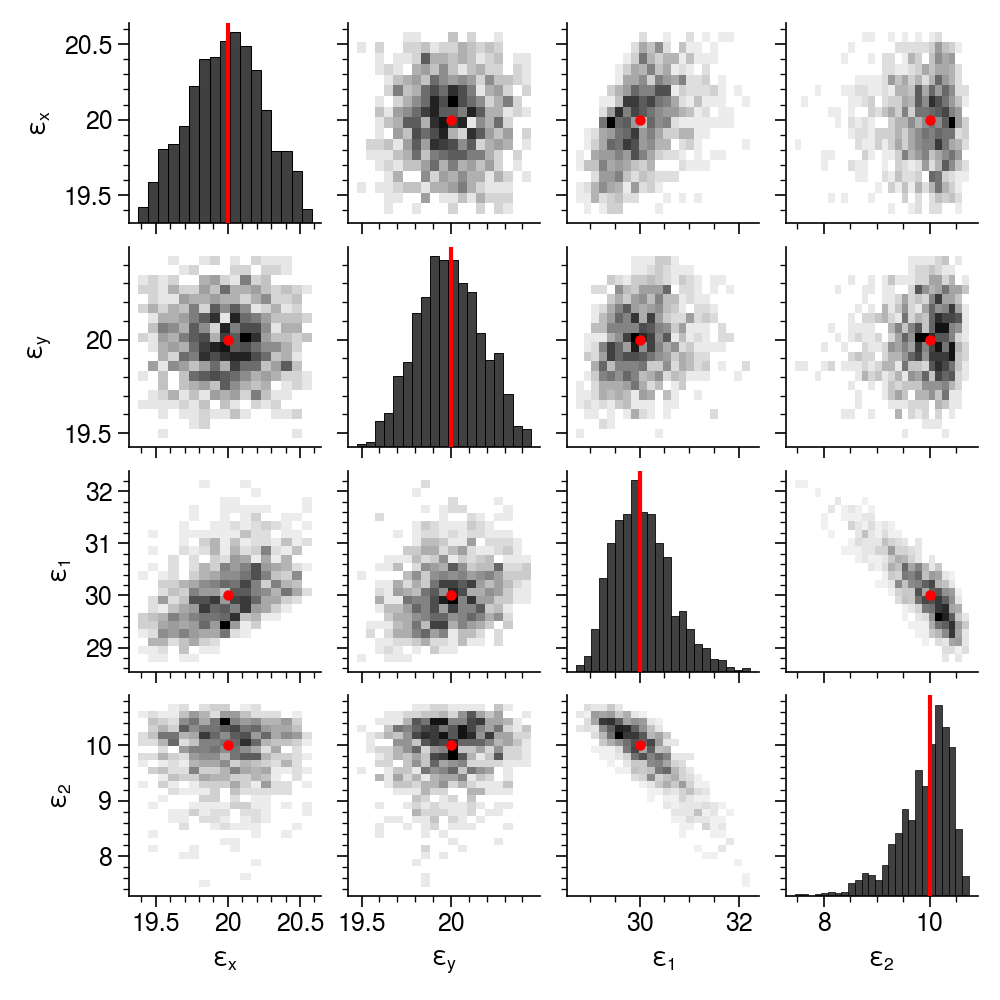

In [19]:
for k in range(4):
    emittances = emittances_list[k]
    eps_true = eps_true_list[k]
    g = sns.pairplot(pd.DataFrame(emittances, columns=eps_labels),
                     kind='hist', corner=False, height=1.25, 
                     diag_kws=dict(color='black'), 
                     plot_kws=dict(cmap=pplt.Colormap('mono', left=0.02)),
                    )
    for i in range(4):
        for j in range(4):
            if i != j:
                g.axes[i, j].scatter(eps_true[j], eps_true[i], c='red', s=10)
            else:
                g.diag_axes[j].axvline(eps_true[j], c='red')
    # plt.suptitle('meas_index = {}'.format(meas_index))
    #     plt.tight_layout()
    # plt.savefig('_output/figures/eps_rand_{}'.format(meas_index))
    plt.show()

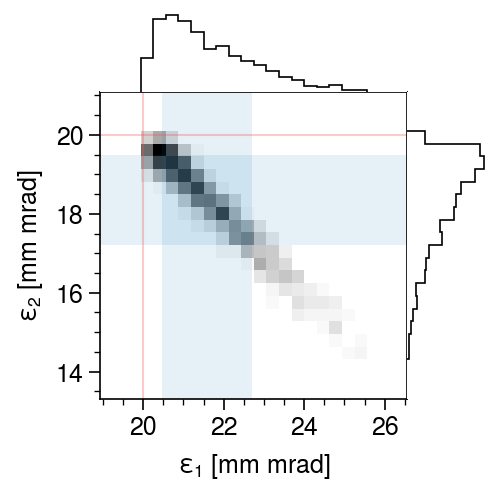

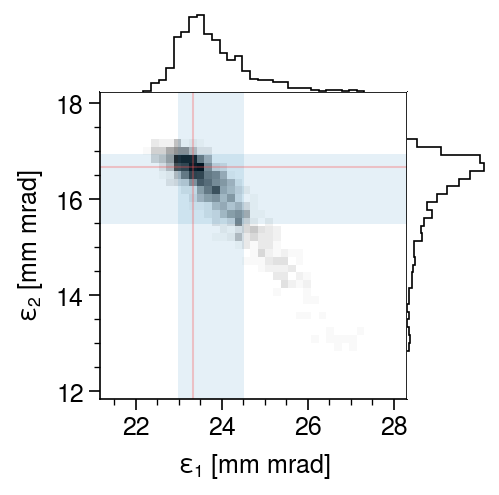

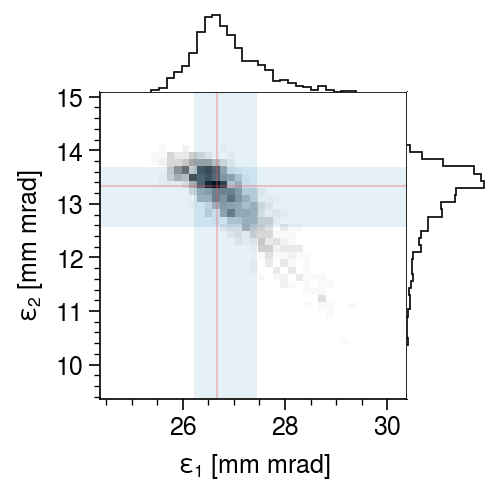

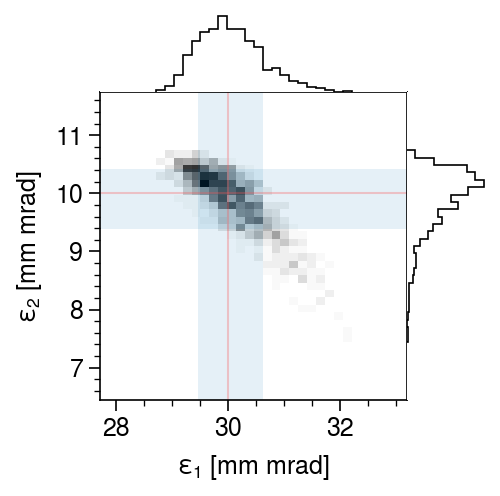

In [20]:
for k in range(4):
    emittances = emittances_list[k]
    eps_true = eps_true_list[k]
    fig, ax = pplt.subplots(figwidth=2.5)
    
    x, y = emittances[:, 2:].T
    pad = 0.0
    xmin = np.min(x) - pad
    xmax = np.max(x) + pad
    ymin = np.min(y) - pad
    ymax = np.max(y) + pad
    bins = 'auto'
    xedges = np.histogram_bin_edges(x, bins, (xmin, xmax))
    yedges = np.histogram_bin_edges(y, bins, (ymin, ymax))
    f, _, _ = np.histogram2d(x, y, bins=[xedges, yedges])
    fx = np.sum(f, axis=1)
    fy = np.sum(f, axis=0)
    
#     ax.scatter(x, y, c='k', s=2)
    ax.pcolormesh(xedges, yedges, np.ma.masked_less_equal(f.T, 0.0), 
                  cmap=pplt.Colormap('mono', left=0.02), ec='None'
                 )
#     sns.histplot(x=x, y=y, ax=ax, cmap=pplt.Colormap('mono', left=0.02))
#     ax.hist2d(x, y, bins='auto', cmap=pplt.Colormap('mono', left=0.02))
    
    line_kws = dict(c='red6', alpha=0.3, lw=0.75)
#     ax.scatter(eps_true[2], eps_true[3], )
    ax.axvline(eps_true[2], **line_kws)
    ax.axhline(eps_true[3], **line_kws)
    
    paxes = [ax.panel_axes(s, share=False, space=0, width=0.4) for s in ['t', 'r']]
    hist_kws = dict(color='black', histtype='step')
    paxes[0].hist(x, xedges, **hist_kws)
    paxes[1].histh(y, yedges, **hist_kws)
    paxes[0].format(xticks=[], yticks=[])
    for pax in paxes:
        pax.format(xspineloc='neither', yspineloc='neither', 
                   xticklabels=[], yticklabels=[])
        
    pad = 1.0
    xlim = (np.min(x) - pad, np.max(x) + pad)
    ylim = (np.min(y) - pad, np.max(y) + pad)
    ax.format(xlim=xlim, ylim=ylim)
    paxes[0].format(xlim=xlim)
    paxes[1].format(ylim=ylim)
    
    line_kws['c'] = 'blue6'
#     ax.axhline(np.mean(y), **line_kws)
#     ax.axvline(np.mean(x), **line_kws)
    kws = dict(alpha=0.1)
    ax.axvspan(np.mean(x) - np.std(x), np.mean(x) + np.std(x), **kws)
    ax.axhspan(np.mean(y) - np.std(y), np.mean(y) + np.std(y), **kws)
#         ax.scatter(np.mean(x), np.mean(y))
            
#     sns.jointplot(x=emittances[:, 2], y=emittances[:, 3], ax=ax)
    ax.format(xlabel=eps_labels[2] + ' [mm mrad]',
              ylabel=eps_labels[3] + ' [mm mrad]')

Altogether now.

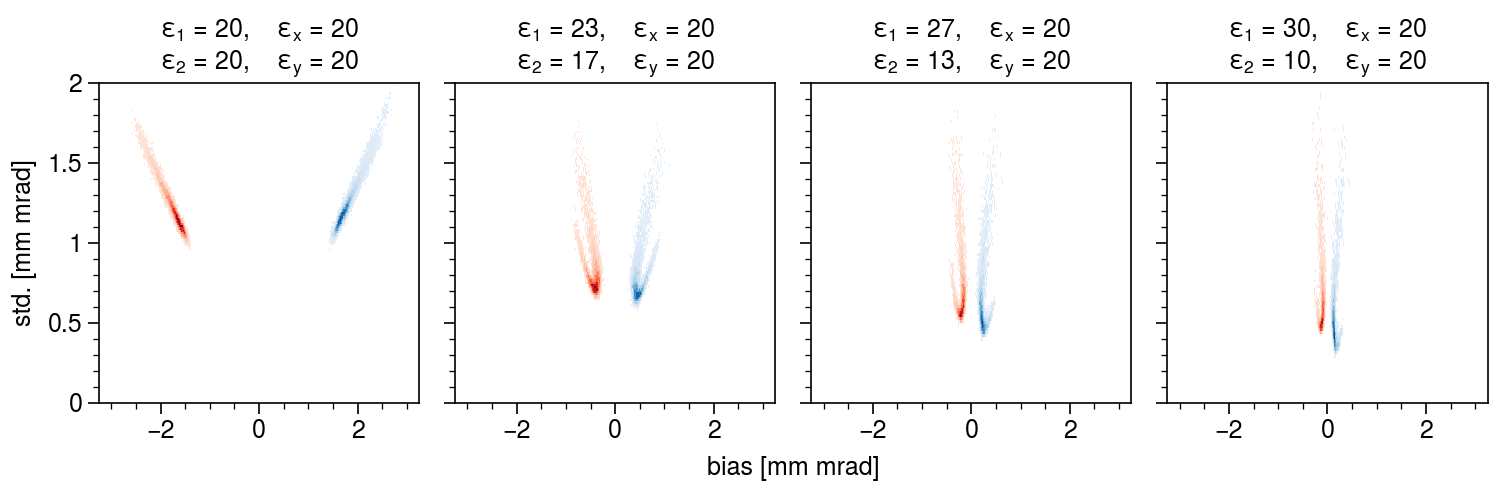

In [21]:
lims = [(-3.25, 3.25), (0.0, 2.0)]
label_kw = dict(fontsize=None)

fig, axes = pplt.subplots(ncols=4, figwidth=7.5)
axes.format(xlim=lims[0], ylim=lims[1], xlabel='bias [mm mrad]', ylabel='std. [mm mrad]',
            xlabel_kw=label_kw, ylabel_kw=label_kw, title_kw=label_kw)
for ax, run in zip(axes, run_indices):
    eps_true = eps_true_list[run]
    xdata = errs_list[run]
    ydata = stds_list[run]
    mappables = []
    for i in ([2, 3]):
        x = xdata[..., i].values.ravel()
        y = ydata[..., i].values.ravel()
        xedges = np.histogram_bin_edges(x, 'auto', lims[0])
        yedges = np.histogram_bin_edges(y, 'auto', lims[1])
        Z, _, _ = np.histogram2d(x, y, bins=[xedges, yedges])
        Z = np.ma.masked_less_equal(Z, 0.0)
        m = ax.pcolormesh(xedges, yedges, Z.T, cmap=cmaps[i - 2], ec='None')
        mappables.append(m)
#         sns.histplot(ax=ax, x=x, y=y, binrange=lims, cmap=cmaps[i - 2], ec='None')
    string1 = fr'$\varepsilon_1$ = {eps_true[2]:.0f},    $\varepsilon_x$ = {eps_true[0]:.0f}'
    string2 = fr'$\varepsilon_2$ = {eps_true[3]:.0f},    $\varepsilon_y$ = {eps_true[1]:.0f}'
    ax.format(title=''.join([string1, '\n', string2]))
    
plt.show()

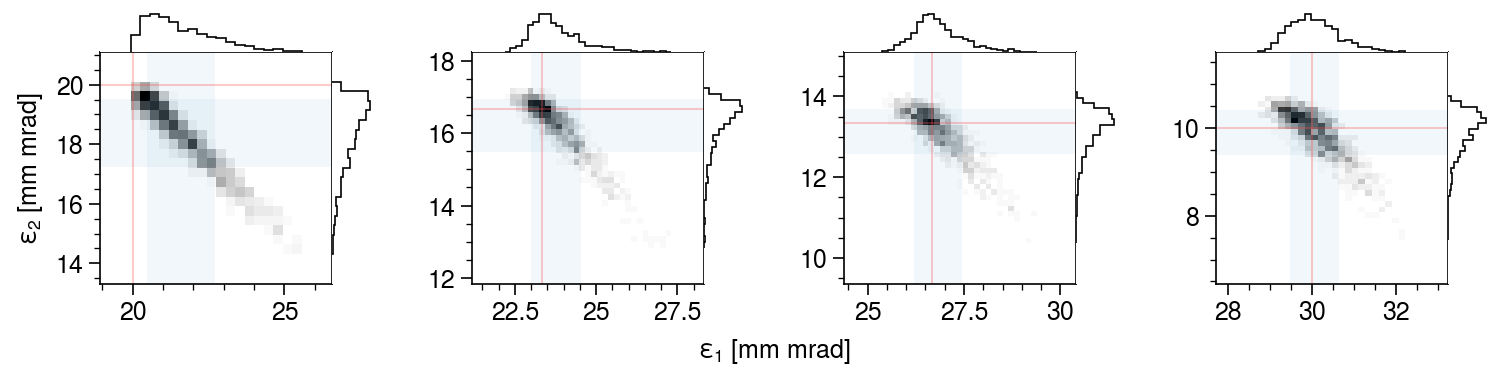

In [22]:
fig, axes = pplt.subplots(ncols=4, figwidth=7.5, share=1, space=4)

for k, ax in enumerate(axes):
    
    emittances = emittances_list[k]
    eps_true = eps_true_list[k]
    
    x, y = emittances[:, 2:].T
    pad = 0.0
    xmin = np.min(x) - pad
    xmax = np.max(x) + pad
    ymin = np.min(y) - pad
    ymax = np.max(y) + pad
    bins = 'auto'
    xedges = np.histogram_bin_edges(x, bins, (xmin, xmax))
    yedges = np.histogram_bin_edges(y, bins, (ymin, ymax))
    f, _, _ = np.histogram2d(x, y, bins=[xedges, yedges])
    fx = np.sum(f, axis=1)
    fy = np.sum(f, axis=0)
    
#     ax.scatter(x, y, c='k', s=2)
    ax.pcolormesh(xedges, yedges, np.ma.masked_less_equal(f.T, 0.0), 
                  cmap=pplt.Colormap('mono', left=0.02), ec='None'
                 )
#     sns.histplot(x=x, y=y, ax=ax, cmap=pplt.Colormap('mono', left=0.02))
#     ax.hist2d(x, y, bins='auto', cmap=pplt.Colormap('mono', left=0.02))
    
    line_kws = dict(c='red6', alpha=0.3, lw=0.75)
#     ax.scatter(eps_true[2], eps_true[3], )
    ax.axvline(eps_true[2], **line_kws)
    ax.axhline(eps_true[3], **line_kws)
    
    pad = 1.0
    xlim = (np.min(x) - pad, np.max(x) + pad)
    ylim = (np.min(y) - pad, np.max(y) + pad)
    ax.format(xlim=xlim, ylim=ylim)
    
    paxes = [ax.panel_axes(s, share=False, space=0, width=0.2) for s in ['t', 'r']]
    hist_kws = dict(color='black', histtype='step')
    paxes[0].hist(x, xedges, **hist_kws)
    paxes[1].histh(y, yedges, **hist_kws)
    paxes[0].format(xticks=[], yticks=[])
    for pax in paxes:
        pax.format(xspineloc='neither', yspineloc='neither', 
                   xticklabels=[], yticklabels=[])
    paxes[0].format(xlim=xlim)
    paxes[1].format(ylim=ylim)
    
    line_kws['c'] = 'blue6'
#     ax.axhline(np.mean(y), **line_kws)
#     ax.axvline(np.mean(x), **line_kws)
    kws = dict(alpha=0.05)
    ax.axvspan(np.mean(x) - np.std(x), np.mean(x) + np.std(x), **kws)
    ax.axhspan(np.mean(y) - np.std(y), np.mean(y) + np.std(y), **kws)
#         ax.scatter(np.mean(x), np.mean(y))
            
#     sns.jointplot(x=emittances[:, 2], y=emittances[:, 3], ax=ax)
    ax.format(xlabel=eps_labels[2] + ' [mm mrad]', ylabel=eps_labels[3]+' [mm mrad]')

with pplt.rc.context(savefigdpi=700):
    plt.savefig('_output/figures/fig5b')